### Run the first cell only when in Google Colab

In [ ]:
# !pip3 install ipympl
# from google.colab import output
# output.enable_custom_widget_manager()

In [10]:
%matplotlib ipympl
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.special import erf

from IPython.display import HTML
from IPython.display import YouTubeVideo
from IPython.display import Image

# Brownian motion

Brownian motion phenomenon is named after Scottish botanist Robert Brown, who in 1827
observed random, leaping movement of plant pollen suspended on the surface of water 

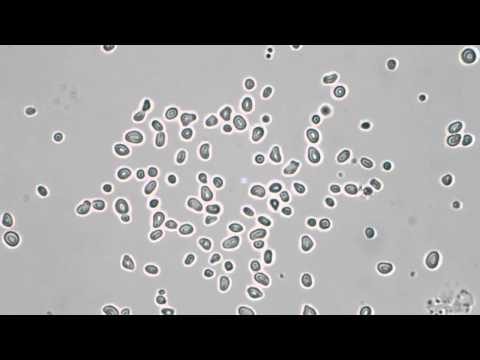

In [6]:
YouTubeVideo('R5t-oA796to')

The phenomenon was rather mysterious at that time, and the explanation was provided only in the next century, independently by three scholars: Albert Einstein, William Sutherland, and Marian Smoluchowski. In 1926, Jean Baptiste Perrin received a Nobel Prize in Physics for experimentally confirming Einstein’s theory.

Brownian motion emerges as a result of particle's collisions (around $10^{14}$ collisions per second, to be precise) with the molecules constituting the surrounding fluid.

The essential conclusions from the Brownian motion theory are:
(1) after some initial time, referred to as momentum relaxation time, the increase in Meam Squared Displacement ($\mathrm{MSD}(t) = \langle \vert\mathbf{r}(t)-\mathbf{r}(0)\vert^2 \rangle$) of independent $d$-dimensional Brownian particles is linear ($\mathrm{MSD}(t)=2dDt$), which is a characteristic feature of diffusion, as compared to ballistic motion for which it is quadratic;
(2) the diffusion coefficient $D$ depends on temperature $T$, viscosity $\eta$, and size
of a Brownian particle $R$, as dictated by the Stokes-Einstein relation ($D=k_\mathrm{B}T/6\pi\eta R$).

# Brownian motion in biological contexts

In 2010, Sean R. McGuffee and Adrian H. Elcock reported large-scale simulations of molecular behavior inside a biological cell.

Link to the paper: https://doi.org/10.1371/journal.pcbi.1000694

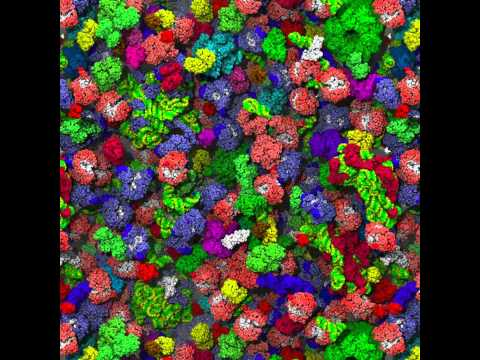

In [5]:
YouTubeVideo('2fobDHHl11c')

Although the Brownian motion inside biological cells is much more complex than in dilute solutions, as the particles interact with each other, and the system is heterogeneous, the 'engine' of their motion is to large extent the same.

You can find more about diffusion in biological cells here: https://book.bionumbers.org/what-are-the-time-scales-for-diffusion-in-cells/

In [11]:
Image(url='https://book.bionumbers.org/wp-content/uploads/2014/08/405-t1-DiffusiveTimeScales-1.png') 

In [ ]:
import pygrpy

# streptavidin_pdb = pygrpy.pdb_loader.get_pdb_from_pdb("1DF8")
streptavidin_pdb = pygrpy.pdb_loader.get_pdb_from_pdb("6VJK")
coordinates, radii = pygrpy.pdb_loader.centres_and_radii(streptavidin_pdb)
pygrpy.grpy.stokesRadius(coordinates, radii)

Sending GET request to https://files.rcsb.org/download/6VJK.pdb to fetch 6VJK's PDB file as a string.


# Hands-on experience

In [ ]:
# function computing a stochastic trajectory of a single particle
def random_walk(num_steps, dt, D, start, box_length):
    std_dev = np.sqrt(2*D*dt)
    if start == "center": start_pos = np.ones(3)*0.5*box_length # particle starts at box center
    elif start == "random": start_pos = np.random.random(3)*box_length # particle starts at random position
    steps = np.random.normal(0.0, std_dev, size=(num_steps, 3)) # random steps are drawn from normal distribution
    walk = start_pos + np.cumsum(steps, axis=0) # trajectory is a cumulative sum of the random steps
    for frame in walk:
        for i in range(3):
            # if particle exits the box, it is moved to its opposite end (periodic boundary conditions)
            while frame[i] > box_length:
                frame[i] -= box_length
            while frame[i] < 0.0:
                frame[i] += box_length
    return walk

# function updating lines plotted at the animated plot
def update_lines(num, walks, dt, lines, ax):
    for line, walk in zip(lines, walks):
        line.set_data(walk[num-1:num, :2].T)
        line.set_3d_properties(walk[num-1:num, 2])
        ax.set_title('Time={} ps'.format(num*dt))
    return lines

# main function computing stochastic trajectories of a set of particles
def perform_bd(num_steps, dt, D, start, num_particles, box_length):
    return [random_walk(num_steps, dt, D, start, box_length) for index in range(num_particles)]

# function visualizing stochastic motion of particles
def vis(walks, dt, box_length):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    num_steps = np.shape(walks)[1]
    lines = [ax.plot([], [], [], 'o')[0] for _ in walks]
    ax.set(xlim3d=(0, box_length), xlabel='X (nm)')
    ax.set(ylim3d=(0, box_length), ylabel='Y (nm)')
    ax.set(zlim3d=(0, box_length), zlabel='Z (nm)')
    ani = animation.FuncAnimation(
        fig, update_lines, num_steps, fargs=(walks, dt, lines, ax), interval=100)
#     ani.save('test.mp4')
#     plt.show()
    html = HTML(ani.to_jshtml())
    display(html)

# function counting particles in a given cuboid defined by three pairs of numbers representing three ranges
def count_in_subbox(traj, subbox):
    num_steps = np.shape(traj)[1]
    num_particles = np.shape(traj)[0]
    count = np.zeros(num_steps, dtype = int)
    for j in range(num_steps):
        for k in range(num_particles):
            if traj[k][j][0] >= subbox[0][0] and traj[k][j][0] <= subbox[0][1]:
                if traj[k][j][1] >= subbox[1][0] and traj[k][j][1] <= subbox[1][1]:
                    if traj[k][j][2] >= subbox[2][0] and traj[k][j][2] <= subbox[2][1]:
                        count[j] += 1
                    else:
                        continue
                else:
                    continue
            else:
                continue
    return count

# function visualizing cuboid and concentration in cuboid in time
def vis_subbox(subbox_definition, particle_count, num_particles, dt, box_length):
    fig, ax = plt.subplots()
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches( (DefaultSize[0], DefaultSize[1]) )
    nx=2
    ny=2
    grid = plt.GridSpec(nrows=ny, ncols=nx, wspace=0.5, hspace=0.7)
    axa = plt.subplot(grid[0, 0], projection="3d")
    axb = plt.subplot(grid[0, 1])
    axc = plt.subplot(grid[1, 0])
    axd = plt.subplot(grid[1, 1])
    axc.axis('off')
    axd.axis('off')
    vertices = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
    [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]], dtype=int)
    vertices = np.array(subbox_definition)[np.arange(3)[np.newaxis, :].repeat(8, axis=0), vertices]
    edges = np.array([[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6],
    [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]], dtype=int)
    _ = axa.set_xlim((0,box_length))
    _ = axa.set_ylim((0,box_length))
    _ = axa.set_zlim((0,box_length))
    _ = axa.set_xlabel('X (nm)')
    _ = axa.set_ylabel('Y (nm)')
    _ = axa.set_zlabel('Z (nm)')
#     _ = axa.plot(*vertices.T, 'o', color = 'red')
    for i, j in edges:
        _ = axa.plot(*vertices[[i, j], :].T, color='r', ls='-')
    _ = axb.set_ylim((-10, num_particles+10))
    _ = axb.set_xlabel('Time (ps)')
    _ = axb.set_ylabel('Particle count')
    _ = axb.plot(dt*np.arange(1,len(particle_count)+1), particle_count)
    
def write_xyz_to_file(traj, filename, dt):
    with open(filename, 'w') as output_file:
        for n_timestep in range(len(traj[0])):
            output_file.write('{}\n'.format(len(traj)))
            output_file.write('{} time {} ps\n'.format(filename, (n_timestep+1)*dt))
            for n_particle in range(len(traj)):
                output_file.write('X{} {} {} {}\n'.format(n_particle+1, *traj[n_particle][n_timestep]))        

# Task 1
We initialize the simulation by placing particles in the center of simulation box. Then, their trajectories are computed using a following scheme:
$$\boldsymbol{r}\left(t+\Delta t\right) = \boldsymbol{r}\left(t \right) + \sqrt{2 D \Delta t} \boldsymbol{X} ,$$
where $\boldsymbol{r}$ is particle's position, $t$ is time, $\Delta t$ is simulation timestep, $D$ is particle's diffusion coefficient, and $\boldsymbol{X}$ is three-dimensional vector, components of which are standard normal random variables (of zero mean and unit variance).

In [ ]:
plt.close()
np.random.seed(19680801) # seed used to initialize pseudorandom number generator
# same seed means same random numbers!
box_length = 20.0 # length of the simulation cubic box side in nanometers
num_particles = 200 # number of diffusing particles
num_steps = 10000 # number of steps in simulation
dt = 1 # size of the timestep in picoseconds
D = 0.00004 # diffusion coefficient in nanometer squared per picosecond
traj = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
plot_every_N_steps = 100 # we cannot visualize every simulation step, because it quickly becomes too memory-consuming
# so in animated figure, we show only timeframes being multiples of N
vis(np.array(traj)[:,::plot_every_N_steps,:], dt*plot_every_N_steps, box_length)
# we can write xyz file with the trajectories of simulated particles
write_xyz_to_file(traj, 'task1.xyz', dt)

To compare theoretical expressions and the simulations, we are going to trace how the number of particles in a small centrally positioned cuboid changes in time.

In [ ]:
plt.close()
subbox_definition = box_length*np.array([[0.49, 0.51], [0.49, 0.51], [0.49, 0.51]]) # here we define the cuboid in which we are going to compute the number of particles vs time
count = count_in_subbox(traj, subbox_definition) # here we compute number of particles in the cuboid vs time
vis_subbox(subbox_definition, count, num_particles, dt, box_length) # here we visualize the cuboid and the number of particles in it vs time
# last argument is the total number of particles, which allows to set the range of y axis

Theoretically, assuming infinite box (which is reasonable, as in the course of simulation particles do not approach the box edges), the density of particles diffusing from a point source at $x_0 = (0.5L,0.5L,0.5L)$ spreads in a following way:
$$n_\mathrm{particles}\left(t;x,y,z\right) = N_\mathrm{particles} \left( 4\pi D t \right)^{-3/2} \exp \left[ -\frac{\left(x-0.5L\right)^2 + \left(y-0.5L\right)^2 + \left(z-0.5L\right)^2}{4Dt} \right] . $$
To obtain the number of particles in a finite cuboid, we integrate the expression above to obtain:
$$N_\mathrm{particles}\left( t; x_1, x_2, y_1, y_2, z_1, z_2 \right) = \left( \frac{1}{2} \right)^3 N_\mathrm{particles} \cdot \left[ \mathrm{erf}\left( \frac{x_2-0.5L}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{x_1-0.5L}{\sqrt{4Dt}} \right] \right) \cdot \left[ \mathrm{erf}\left( \frac{y_2-0.5L}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{y_1-0.5L}{\sqrt{4Dt}} \right) \right] \cdot \left[ \mathrm{erf}\left( \frac{z_2-0.5L}{\sqrt{4Dt}} \right) - \mathrm{erf}\left( \frac{z_1-0.5L}{\sqrt{4Dt}} \right) \right] $$
where $x_1, x_2, y_1, y_2, z_1, z_2$ are limits of ranges defining the cuboid, $N_\mathrm{particles}$ is the total number of particles in whole simulation box, and $\mathrm{erf}$ is the [error function](https://en.wikipedia.org/wiki/Error_function). We are going to compare the results of the expression above and the simulations.

In [ ]:
_ = plt.close()
t = dt*np.arange(1, (len(count)+1))
theory = num_particles/8 * ( erf((subbox_definition[0][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[0][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[1][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[1][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[2][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[2][0]-0.5*box_length)/np.sqrt(4*D*t)) )
_ = plt.plot(t, theory, '-', color = 'red', label = 'theory')
_ = plt.plot(t, count, ':', color = 'black', label = 'sim.')
_ = plt.legend()
_ = plt.xlabel('Time (ps)')
_ = plt.ylabel('Particle count')

# Task 2
We now increase the diffusion coefficient slightly, and monitor the number of particles in a cuboid, which initially does not contain any.

In [ ]:
plt.close()
np.random.seed(93843734)
box_length = 20.0
num_particles = 600 # number of particles is larger now
num_steps = 10000
dt = 50.0
D = 0.000040
traj = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length=box_length)
plot_every_N_steps = 100
vis(np.array(traj)[:,::plot_every_N_steps,:], dt*plot_every_N_steps, box_length)
write_xyz_to_file(traj, 'task2.xyz', dt)

In [ ]:
plt.close()
subbox_definition = box_length*np.array([[0.3, 0.45], [0.3, 0.45], [0.45, 0.55]])
count = count_in_subbox(traj, subbox_definition)
vis_subbox(subbox_definition, count, num_particles, dt, box_length)

In [ ]:
_ = plt.close()
t = dt*np.arange(1, len(count)+1)
theory = num_particles/8 * ( erf((subbox_definition[0][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[0][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[1][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[1][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[2][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[2][0]-0.5*box_length)/np.sqrt(4*D*t)) )
_ = plt.plot(t, theory, '-', color = 'red', label = 'theory')
_ = plt.plot(t, count, ':', color = 'black', label = 'sim.')
_ = plt.legend()
_ = plt.xlabel('Time (ps)')
_ = plt.ylabel('Particle count')

Let's now repeat simulation a few times and average the results to acquire better statistics, i.e., less noisy line.

In [ ]:
plt.close()
np.random.seed(101)
traj1 = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
np.random.seed(301)
traj2 = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
np.random.seed(501)
traj3 = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
np.random.seed(701)
traj4 = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
np.random.seed(901)
traj5 = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
counts = [ count_in_subbox(t, subbox_definition) for t in [traj, traj1, traj2, traj3, traj4, traj5] ]

In [ ]:
_ = plt.close()
t = dt*np.arange(1, len(count)+1)
theory = num_particles/8 * ( erf((subbox_definition[0][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[0][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[1][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[1][0]-0.5*box_length)/np.sqrt(4*D*t)) ) \
                         * ( erf((subbox_definition[2][1]-0.5*box_length)/np.sqrt(4*D*t)) - erf((subbox_definition[2][0]-0.5*box_length)/np.sqrt(4*D*t)) )
_ = plt.plot(t, theory, '-', color = 'red', label = 'theory')
_ = plt.plot(t, np.mean(counts, axis=0), ':', color = 'black', label = 'sim. (mean)')
_ = plt.legend()
_ = plt.xlabel('Time')
_ = plt.ylabel('Particle count')

# Task 3
Now, we increase the diffusion coefficient, so that the particles reach the boundary and mix well. If particle exits the box from one side, it appears at the opposite side (so-called periodic boundary conditions).

In [ ]:
plt.close()
np.random.seed(4383743)
box_length = 20.0
num_particles = 200
num_steps = 10000
dt = 500.0
D = 0.000040 # the diffusion coefficients is now 1000 times higher than initially
traj = perform_bd(num_steps=num_steps, dt = dt, D = D, start="center", num_particles=num_particles, box_length = box_length)
plot_every_N_steps = 100
vis(np.array(traj)[:,::plot_every_N_steps,:], dt*plot_every_N_steps, box_length)
write_xyz_to_file(traj, 'task3.xyz', dt)

In [ ]:
plt.close()
subbox_definition = box_length*np.array([[0.5, 1.0], [0.0, 0.5], [0.0, 1.0]])
count = count_in_subbox(traj, subbox_definition)
vis_subbox(subbox_definition, count, num_particles, dt, box_length)

If the particles are well-mixed, the fraction of particles in a given cuboid is equal to the ratio of the cuboid's volume to the box volume.

In [ ]:
_ = plt.close()
t = dt*np.arange(1, len(count)+1)
volume = (subbox_definition[0][1]-subbox_definition[0][0])*(subbox_definition[1][1]-subbox_definition[1][0])*(subbox_definition[2][1]-subbox_definition[2][0])
theory = num_particles * volume * np.ones(len(count)) / box_length**3
_ = plt.plot(t, theory, '-', color = 'red', label = 'theory')
_ = plt.plot(t, count, ':', color = 'black', label = 'sim.')
_ = plt.legend()
_ = plt.xlabel('Time (ps)')
_ = plt.ylabel('Particle count')